In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [2]:
# import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

print(is_cuda_gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [3]:
pip install Keras-Preprocessing

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# import wget
# wget.download("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [6]:
# !gdown 1sbMNX22CRM6nj8c8LSQ8NGPOLL68yzdf

In [7]:
# !gdown 1orcRXBBvXXC4uLes226LtKChoGLpdWoB

In [8]:
# !unzip non_smokers.zip -d non_smokers

In [9]:
# !unzip smokers.zip -d smokers

In [ ]:
import cv2
import glob
import numpy as np

smoking_data = []
# counter = 0
files = glob.glob ("smokers/*.jpg")
for myFile in files:
  # if counter > 2:
  #   break
  # print(myFile)
  image = cv2.imread(myFile)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  smoking_data.append (image)
  print('smoking_data shape:', np.array(smoking_data).shape)
#   counter = counter + 1

smoking_data = np.asarray(smoking_data)
print(smoking_data.shape)

In [11]:
smoking_data[0].shape

(250, 250, 3)

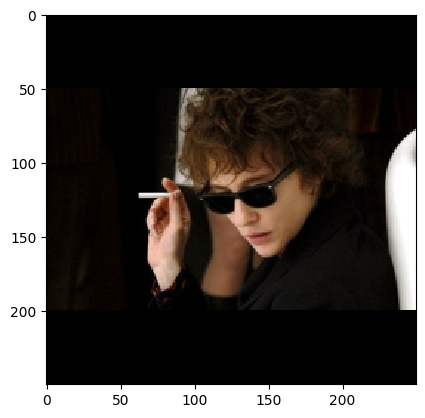

In [12]:
from matplotlib import pyplot as plt
plt.imshow(smoking_data[301], interpolation='nearest')
plt.show()

In [ ]:
import cv2
import glob
import numpy as np

not_smoking_data = []
# counter = 0
files = glob.glob ("non_smokers/*.jpg")
for myFile in files:
  # if counter > 2:
  #   break
  print(myFile)
  image = cv2.imread(myFile)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  not_smoking_data.append (image)
  print('not_smoking_data shape:', np.array(not_smoking_data).shape)
#   counter = counter + 1

not_smoking_data = np.asarray(not_smoking_data)
print(not_smoking_data.shape)

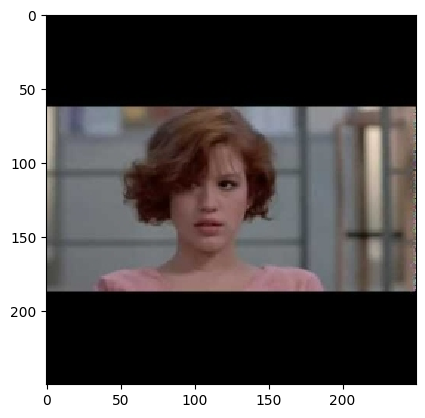

In [14]:
from matplotlib import pyplot as plt
plt.imshow(not_smoking_data[0], interpolation='nearest')
plt.show()

In [15]:
smoking_data[0].shape

(250, 250, 3)

In [16]:
# Data not normalized
print(smoking_data[smoking_data>254])
print(not_smoking_data[not_smoking_data>254])

[255 255 255 ... 255 255 255]
[255 255 255 ... 255 255 255]


In [17]:
# Data normalization
smoking_data, not_smoking_data = smoking_data / 255.0, not_smoking_data / 255.0
# Check data normalized
print(not_smoking_data[not_smoking_data>=1])

[1. 1. 1. ... 1. 1. 1.]


In [18]:
# Making Labels
smoking = 1
not_smoking = 0

smoking_labels = np.zeros(smoking_data.shape[0], dtype=np.int32)
not_smoking_labels = np.ones(not_smoking_data.shape[0], dtype=np.int32)

all_labels = np.concatenate((smoking_labels, not_smoking_labels))

all_labels_categorical = tf.keras.utils.to_categorical(all_labels, num_classes=2)

In [19]:
print (all_labels.shape)
# print (all_labels[3274])
print (all_labels_categorical[1997])
print (all_labels_categorical.shape)

(3275,)
[0. 1.]
(3275, 2)


In [20]:
all_labels_categorical.shape

(3275, 2)

In [21]:
# STACK ALL DATA TOGETHER
all_input_data = np.vstack((smoking_data,not_smoking_data))
all_input_data.shape

(3275, 250, 250, 3)

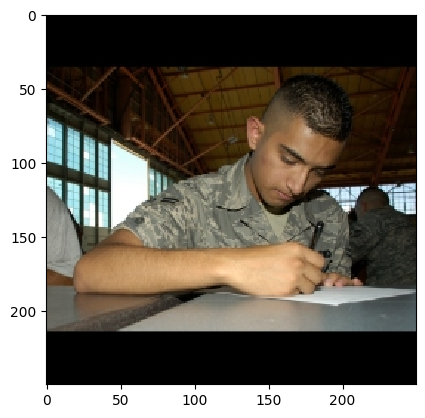

In [22]:
from matplotlib import pyplot as plt
plt.imshow(all_input_data[3274], interpolation='nearest')
plt.show()

In [23]:
# STACK ALL LABELS TOGETHER
# all_labels_categorical already made

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_input_data, all_labels_categorical, test_size=0.2, random_state=42)

In [25]:
print("X train: " + str(X_train.shape))
print("X test: " + str(X_test.shape))
print("y train: " + str(y_train.shape))
print("y test: " + str(y_test.shape))


X train: (2620, 250, 250, 3)
X test: (655, 250, 250, 3)
y train: (2620, 2)
y test: (655, 2)


In [26]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

tf.get_logger().setLevel('ERROR')

Instructions for updating:
non-resource variables are not supported in the long term


In [27]:
# pip install -U TensorFlow-privacy

In [28]:
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [29]:
epochs = 12
batch_size = 131

In [30]:
# Default values
l2_norm_clip = 1.5
noise_multiplier = 3
num_microbatches = batch_size
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [31]:
model_dp_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='valid',
                           activation='relu',
                           input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [32]:
model_dp_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='valid',
                           activation='relu',
                           input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [33]:
model_dp_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='valid',
                           activation='relu',
                           input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [34]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [35]:
checkpoint_dp_1_path = "training_dp_1/cp.ckpt"
checkpoint_dp_1_dir = os.path.dirname(checkpoint_dp_1_path)

# Create a callback that saves the model's weights
cp_dp_1_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dp_1_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [36]:
model_dp_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

hist_dp_1 = model_dp_1.fit(X_train, y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          callbacks=[cp_dp_1_callback])

Train on 2620 samples, validate on 655 samples
Epoch 1/12
2620/2620 [==============================] - ETA: 0s - loss: 1.6222 - acc: 0.5992 

D:\Softwares\Anaconda\envs\dp_3\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: saving model to training_dp_1\cp.ckpt
2620/2620 [==============================] - 932s 356ms/sample - loss: 1.6222 - acc: 0.5992 - val_loss: 0.8386 - val_acc: 0.6519
Epoch 2/12
2620/2620 [==============================] - ETA: 0s - loss: 1.3900 - acc: 0.6256 
Epoch 2: saving model to training_dp_1\cp.ckpt
2620/2620 [==============================] - 934s 356ms/sample - loss: 1.3900 - acc: 0.6256 - val_loss: 1.2157 - val_acc: 0.5954
Epoch 3/12
2620/2620 [==============================] - ETA: 0s - loss: 1.4936 - acc: 0.6351 
Epoch 3: saving model to training_dp_1\cp.ckpt
2620/2620 [==============================] - 930s 355ms/sample - loss: 1.4936 - acc: 0.6351 - val_loss: 1.3353 - val_acc: 0.6794
Epoch 4/12
2620/2620 [==============================] - ETA: 0s - loss: 1.4099 - acc: 0.6733 
Epoch 4: saving model to training_dp_1\cp.ckpt
2620/2620 [==============================] - 929s 355ms/sample - loss: 1.4099 - acc: 0.6733 - val_loss: 2.0910 - val_acc: 0.5817
Epoch 5/12
26

In [37]:
os.listdir(checkpoint_dp_1_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

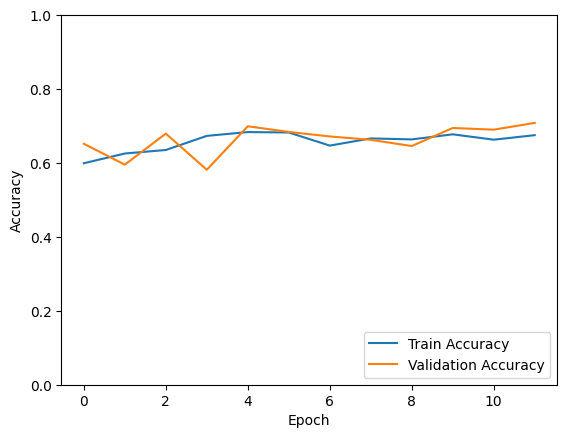

In [61]:
plt.plot(hist_dp_1.history['acc'], label='Train Accuracy')
plt.plot(hist_dp_1.history['val_acc'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
# plt.xticks(np.arange(0, 12, 2))
plt.legend(loc='lower right')

# test_loss, test_acc = model_dp.evaluate(X_test, y_test, verbose=2)

In [58]:
# plt.plot(hist_dp_1.history['loss'], label='accuracy')
# plt.plot(hist_dp_1.history['val_loss'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# # plt.xticks(np.arange(0, 12, 2))
# plt.legend(loc='lower right')

# # test_loss, test_acc = model_dp.evaluate(X_test, y_test, verbose=2)

In [ ]:
hist_dp_1.history

In [39]:
noise_multiplier = 3.5
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

In [40]:
checkpoint_dp_2_path = "training_dp_2/cp.ckpt"
checkpoint_dp_2_dir = os.path.dirname(checkpoint_dp_2_path)

# Create a callback that saves the model's weights
cp_dp_2_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dp_2_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [41]:
model_dp_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

hist_dp_2 = model_dp_2.fit(X_train, y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          callbacks=[cp_dp_2_callback])

Train on 2620 samples, validate on 655 samples
Epoch 1/12
2620/2620 [==============================] - ETA: 0s - loss: 1.8728 - acc: 0.6019 
Epoch 1: saving model to training_dp_2\cp.ckpt
2620/2620 [==============================] - 930s 355ms/sample - loss: 1.8728 - acc: 0.6019 - val_loss: 0.7767 - val_acc: 0.6595
Epoch 2/12
2620/2620 [==============================] - ETA: 0s - loss: 1.4914 - acc: 0.6531 
Epoch 2: saving model to training_dp_2\cp.ckpt
2620/2620 [==============================] - 935s 357ms/sample - loss: 1.4914 - acc: 0.6531 - val_loss: 1.3535 - val_acc: 0.6885
Epoch 3/12
2620/2620 [==============================] - ETA: 0s - loss: 1.8712 - acc: 0.6382 
Epoch 3: saving model to training_dp_2\cp.ckpt
2620/2620 [==============================] - 933s 356ms/sample - loss: 1.8712 - acc: 0.6382 - val_loss: 1.6227 - val_acc: 0.6794
Epoch 4/12
2620/2620 [==============================] - ETA: 0s - loss: 1.9521 - acc: 0.6595 
Epoch 4: saving model to training_dp_2\cp.ckpt
26

In [42]:
os.listdir(checkpoint_dp_2_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

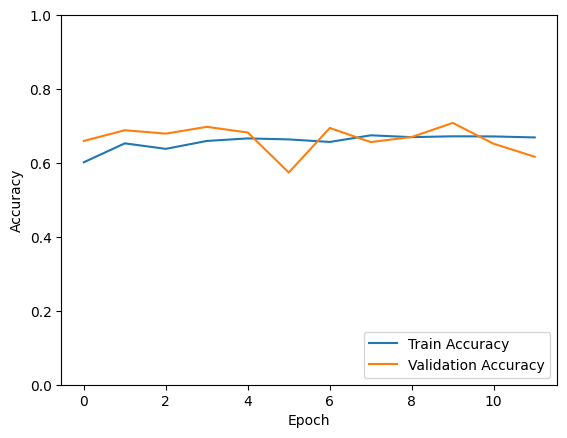

In [62]:
plt.plot(hist_dp_2.history['acc'], label='Train Accuracy')
plt.plot(hist_dp_2.history['val_acc'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
# plt.xlim([0, 2])
plt.legend(loc='lower right')

# test_loss, test_acc = model_dp.evaluate(X_test, y_test, verbose=2)

In [44]:
noise_multiplier = 4
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

In [45]:
checkpoint_dp_3_path = "training_dp_3/cp.ckpt"
checkpoint_dp_3_dir = os.path.dirname(checkpoint_dp_3_path)

# Create a callback that saves the model's weights
cp_dp_3_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dp_3_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [46]:
model_dp_3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

hist_dp_3 = model_dp_3.fit(X_train, y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          callbacks=[cp_dp_3_callback])

Train on 2620 samples, validate on 655 samples
Epoch 1/12
2620/2620 [==============================] - ETA: 0s - loss: 1.7464 - acc: 0.5962 
Epoch 1: saving model to training_dp_3\cp.ckpt
2620/2620 [==============================] - 932s 356ms/sample - loss: 1.7464 - acc: 0.5962 - val_loss: 1.9298 - val_acc: 0.6489
Epoch 2/12
2620/2620 [==============================] - ETA: 0s - loss: 1.8027 - acc: 0.6038 
Epoch 2: saving model to training_dp_3\cp.ckpt
2620/2620 [==============================] - 933s 356ms/sample - loss: 1.8027 - acc: 0.6038 - val_loss: 1.2131 - val_acc: 0.6580
Epoch 3/12
2620/2620 [==============================] - ETA: 0s - loss: 1.6719 - acc: 0.6176 
Epoch 3: saving model to training_dp_3\cp.ckpt
2620/2620 [==============================] - 931s 355ms/sample - loss: 1.6719 - acc: 0.6176 - val_loss: 1.3788 - val_acc: 0.6443
Epoch 4/12
2620/2620 [==============================] - ETA: 0s - loss: 2.1049 - acc: 0.6103 
Epoch 4: saving model to training_dp_3\cp.ckpt
26

In [47]:
os.listdir(checkpoint_dp_3_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

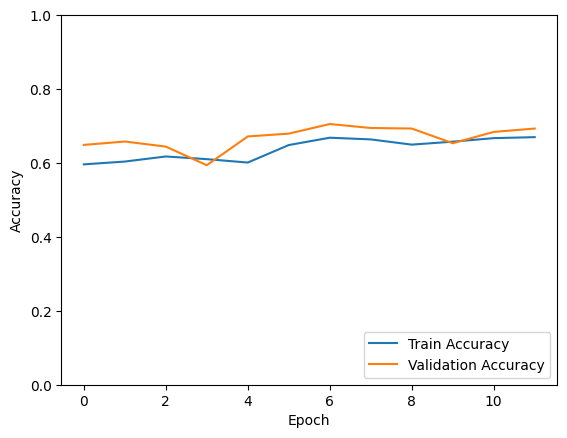

In [63]:
plt.plot(hist_dp_3.history['acc'], label='Train Accuracy')
plt.plot(hist_dp_3.history['val_acc'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
# plt.xlim([0, 2])
plt.legend(loc='lower right')

# test_loss, test_acc = model_dp.evaluate(X_test, y_test, verbose=2)